Quick look at pre-release v3.1 results

Runs in here:
* Previous baselines
    * `retro_baseline_v2.0_10yrs.db` (like v1.x runs)
    * `baseline_v2.0_10yrs.db`
    * `baseline_v2.1_10yrs.db`
    * `baseline_v2.2_10yrs.db`
    * `baseline_v3.0_10yrs.db`
* `starter_v3.1_10yrs.db`
    * update to the footprint to include small Euclid swath
    * update survey start time
    * uzy filter swapping rather than just uz
    * updated to newer cloud database
    * telescope now parks with r-filter in. Should be no filter change time added when coming out of park.
    * updated long gaps survey to only attempt log gaps if early pair was sucessful
    * blobs no longer have az and radius limits (mostly a change for visulization)
    

Runs below are like starter_v3.1 except how noted.

* `m2_starter`
    * same as `starter`, but run on apple silicon. Mostly for checking cross-platform repeatability
* `filtlers_uy`
    * swaps y in for u in bright time
* `filters_uz`
    * swaps z in for u in bright time (like previous baselines)
* `noroll`
    * no rolling candence. Requested by DESC to look at uniformity at data releases
* `old_mjd0_uz`
    * rolling back the survey start date, swapping only u and z filters
* `old_mjd0`
    * rolling back survey start date, swapping u with z & y
* `threeroll`
    * only three seasons of rolling. Looking at final survey uniformity
*  `weather_cloudso...`
    * Varying the start year of our cloud database. Provides a handy way to look at the precision of metric values and the limits to which we can expect to optimize the survey
* `no_plane`, `light_plane`, `heavy_plane`
    * Varying the amount of observing in the dusty plane. Mostly so we can check self calibration schemes. 
* `more_u_utw`
    * Vary the weight on getting u-band templates. Noted starter wasn't doing a great job closing the sky for calibration in year 1



In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')

In [4]:
 [col for col in data_loaded.columns if 'Trojan' in col ]

['CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 1 quad in 1 night detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=0 detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=4 detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=5 detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 15 nights detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 15 nights trailing loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Trojan 3 pairs in 30 nights detection loss MoObjSlicer',
 'CumulativeCompleteness H <= 14.000000 DiscoveryNChances Tr

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',

            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira'}

# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [6]:
data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
baseline_v2.0_10yrs,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,0.282012,37.908126,443.0,3433.0,4544.0,1879.0,168086.074111,0.9294,0.642021,0.719635,1.000000,0.124696,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,0.283756,38.560143,443.0,3585.0,4777.0,1918.0,163815.013503,0.9286,0.647553,0.723197,0.999931,0.129250,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,0.289980,39.794283,440.0,3950.0,5215.0,1920.0,172453.127988,0.9304,0.657476,0.723913,0.999965,0.130637,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,0.293926,38.643260,423.0,4308.0,5654.0,1950.0,168032.537231,0.9326,0.642155,0.722293,0.999965,0.129763,0.0376
filters_uy_v3.1_10yrs,0.806540,0.187590,0.3294,0.4640,799.0,120243.593076,0.304688,39.358925,424.0,3488.0,5327.0,1987.0,173344.061699,0.9288,0.642704,0.721327,0.999888,0.126234,0.0449
filters_uz_v3.1_10yrs,0.806076,0.186520,0.3338,0.4619,800.0,118096.943480,0.301940,39.170122,425.0,3835.0,5834.0,2000.0,172322.268388,0.9266,0.642338,0.722322,0.999831,0.128652,0.0499
heavy_plane_v3.1_10yrs,0.795381,0.188430,0.3249,0.4603,710.0,101676.760188,0.292969,37.543296,373.0,3112.0,4516.0,1958.0,179147.605244,0.9252,0.635575,0.722647,0.999965,0.127224,0.0424
light_plane_v3.1_10yrs,0.815462,0.189759,0.3182,0.4481,828.0,123683.403552,0.304081,39.462747,440.0,3737.0,5692.0,1966.0,165928.961739,0.9298,0.638465,0.717493,0.999931,0.126290,0.0414
m2_starter_v3.1_10yrs,0.807127,0.188456,0.3319,0.4649,795.0,117507.594489,0.303417,39.125955,422.0,3557.0,5276.0,2019.0,171733.956487,0.9284,0.639908,0.722593,0.999965,0.126805,0.0404
more_u_utw_100_v3.1_10yrs,0.833896,0.189066,0.3265,0.4542,793.0,111606.173999,0.299077,38.863389,415.0,3527.0,5352.0,1955.0,169650.658261,0.9248,0.629477,0.719783,0.999931,0.121683,0.0392


In [7]:
data['KNe single model'] # data['KNe ZTF simple']

baseline_v2.0_10yrs            4544.0
baseline_v2.1_10yrs            4777.0
baseline_v2.2_10yrs            5215.0
baseline_v3.0_10yrs            5654.0
filters_uy_v3.1_10yrs          5327.0
filters_uz_v3.1_10yrs          5834.0
heavy_plane_v3.1_10yrs         4516.0
light_plane_v3.1_10yrs         5692.0
m2_starter_v3.1_10yrs          5276.0
more_u_utw_100_v3.1_10yrs      5352.0
more_u_utw_12_v3.1_10yrs       5261.0
more_u_utw_150_v3.1_10yrs      5384.0
more_u_utw_200_v3.1_10yrs      5283.0
more_u_utw_24_v3.1_10yrs       5408.0
more_u_utw_50_v3.1_10yrs       5384.0
no_plane_v3.1_10yrs            5831.0
noroll_v3.1_10yrs              4753.0
old_mjd0_uz_v3.1_10yrs         5651.0
old_mjd0_v3.1_10yrs            5203.0
retro_baseline_v2.0_10yrs      3982.0
starter_v3.1_10yrs             5408.0
threeroll_v3.1_10yrs           5089.0
upu_v3.1_10yrs                 5199.0
weather_cloudso0v3.1_10yrs     5273.0
weather_cloudso10v3.1_10yrs    5526.0
weather_cloudso12v3.1_10yrs    5596.0
weather_clou

In [8]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
data['KNe ZTF simple']

baseline_v2.0_10yrs            3433.0
baseline_v2.1_10yrs            3585.0
baseline_v2.2_10yrs            3950.0
baseline_v3.0_10yrs            4308.0
filters_uy_v3.1_10yrs          3488.0
filters_uz_v3.1_10yrs          3835.0
heavy_plane_v3.1_10yrs         3112.0
light_plane_v3.1_10yrs         3737.0
m2_starter_v3.1_10yrs          3557.0
more_u_utw_100_v3.1_10yrs      3527.0
more_u_utw_12_v3.1_10yrs       3533.0
more_u_utw_150_v3.1_10yrs      3515.0
more_u_utw_200_v3.1_10yrs      3482.0
more_u_utw_24_v3.1_10yrs       3497.0
more_u_utw_50_v3.1_10yrs       3558.0
no_plane_v3.1_10yrs            3819.0
noroll_v3.1_10yrs              3195.0
old_mjd0_uz_v3.1_10yrs         4339.0
old_mjd0_v3.1_10yrs            4032.0
retro_baseline_v2.0_10yrs      2763.0
starter_v3.1_10yrs             3497.0
threeroll_v3.1_10yrs           3411.0
upu_v3.1_10yrs                 3413.0
weather_cloudso0v3.1_10yrs     3499.0
weather_cloudso10v3.1_10yrs    3434.0
weather_cloudso12v3.1_10yrs    3642.0
weather_clou

In [9]:
mag_data

,g,i,r,u,y,z
baseline_v2.0_10yrs,26.733479,26.218659,26.755971,25.818916,24.762720,25.510379
baseline_v2.1_10yrs,26.736248,26.252054,26.781543,25.751969,24.728145,25.486640
baseline_v2.2_10yrs,26.753646,26.290929,26.835430,25.724699,24.782743,25.581317
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
filters_uy_v3.1_10yrs,26.697604,26.291031,26.806902,25.667890,24.765542,25.575543
filters_uz_v3.1_10yrs,26.691517,26.280692,26.829657,25.675637,24.778314,25.557864
heavy_plane_v3.1_10yrs,26.671441,26.257106,26.786712,25.680580,24.750497,25.566143
light_plane_v3.1_10yrs,26.686512,26.287141,26.819933,25.670175,24.785882,25.588538
m2_starter_v3.1_10yrs,26.698000,26.280940,26.811136,25.671228,24.771943,25.560120
more_u_utw_100_v3.1_10yrs,26.660870,26.269130,26.786106,25.795185,24.765407,25.546547


In [10]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335
filters_uy_v3.1_10yrs,392.296186,66.345410,119.120007,31.918175,52.455098,0.597483,0.577995,0.530214,0.595695,0.564129
filters_uz_v3.1_10yrs,377.023944,60.966517,106.881873,33.109030,52.624389,0.596862,0.559737,0.510642,0.581440,0.564676
heavy_plane_v3.1_10yrs,494.692623,265.988504,465.277838,180.748018,204.259975,0.591074,0.580152,0.527244,0.568824,0.566221
light_plane_v3.1_10yrs,495.944050,268.278326,461.637403,176.235935,205.034481,0.586987,0.580488,0.526366,0.569684,0.565378
m2_starter_v3.1_10yrs,493.955456,268.234021,467.454780,175.783421,202.691063,0.592349,0.579559,0.526786,0.569267,0.567768
more_u_utw_100_v3.1_10yrs,492.991131,266.945207,462.443062,180.655006,200.375977,0.592054,0.580188,0.525936,0.568901,0.566366


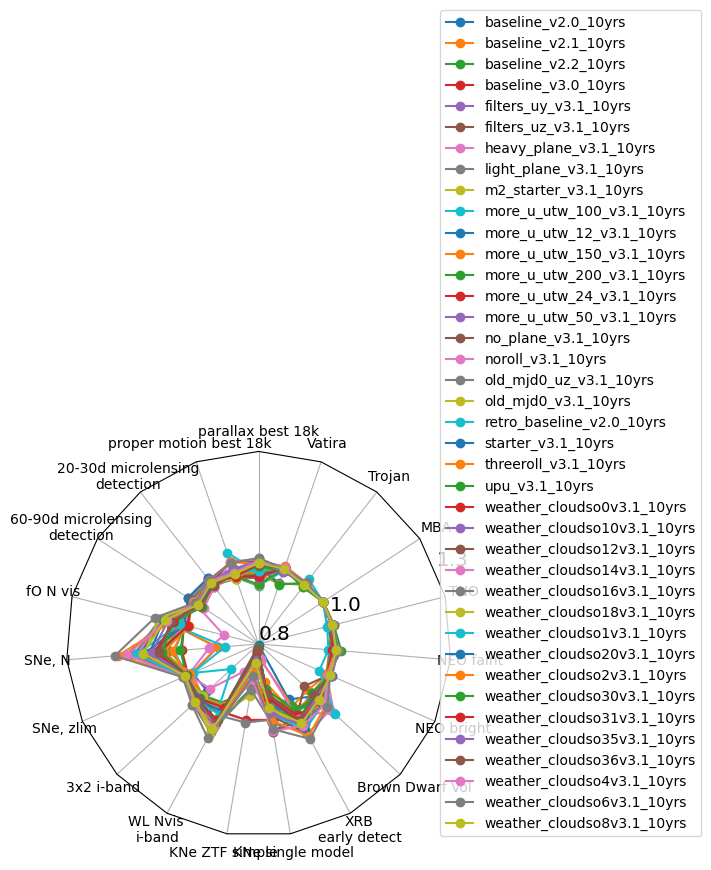

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

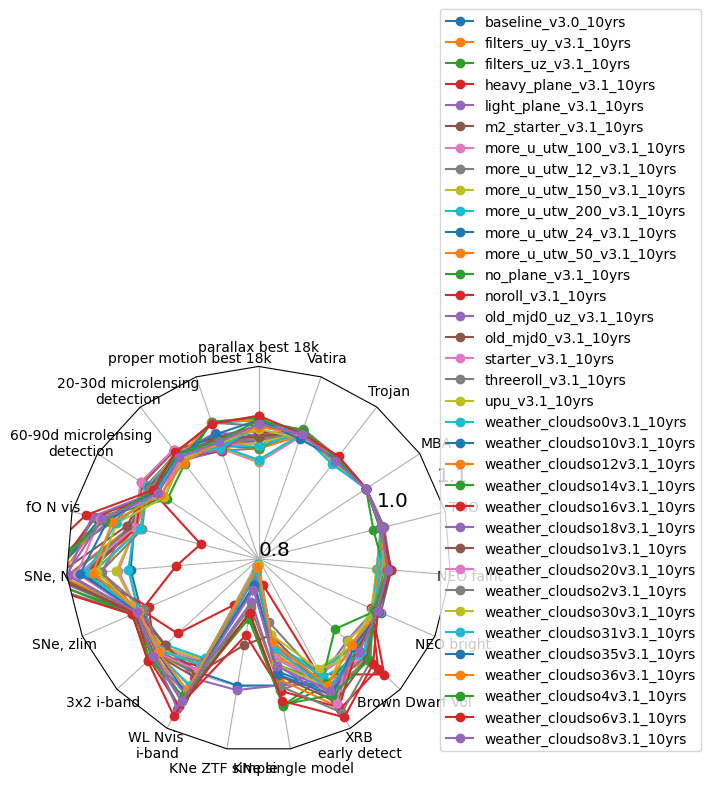

In [12]:
# only 3.x runs

runs = [run for run in data.index if '3.' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

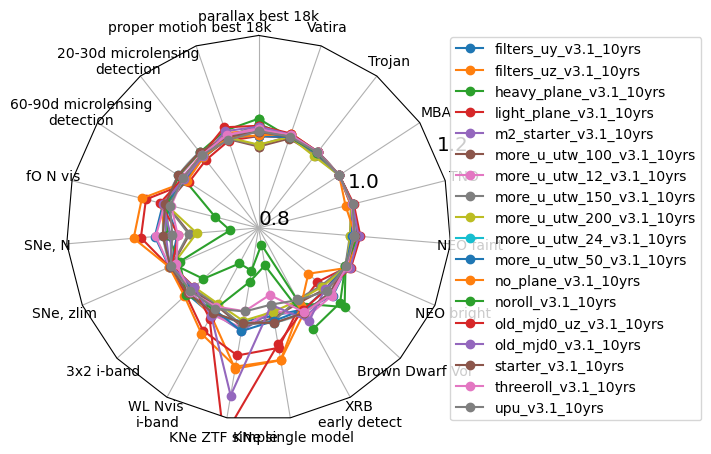

In [13]:
# only 3.1 runs, without the weather

runs = [run for run in data.index if '3.1' in run and 'weather' not in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

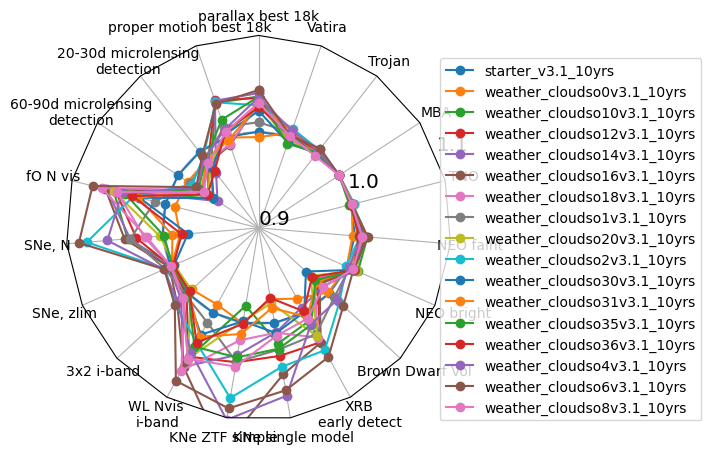

In [14]:
# What happens when we vary the weather?

# 

runs = ['starter_v3.1_10yrs']+ [run for run in data.index if 'weather' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

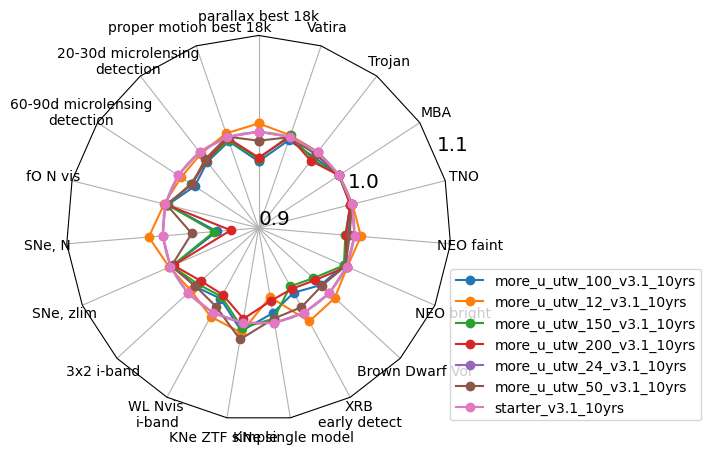

In [15]:
# wow, getting u-band closed in the first year really doesn't seem to help anything! 

runs = [run for run in data.index if '3.1' in run and 'weather' not in run and 'utw' in run] + ['starter_v3.1_10yrs']
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Compare 3.1 and 3.0 median coadded depths.
# Changes of order 0.01 mags, so not really any change at all.

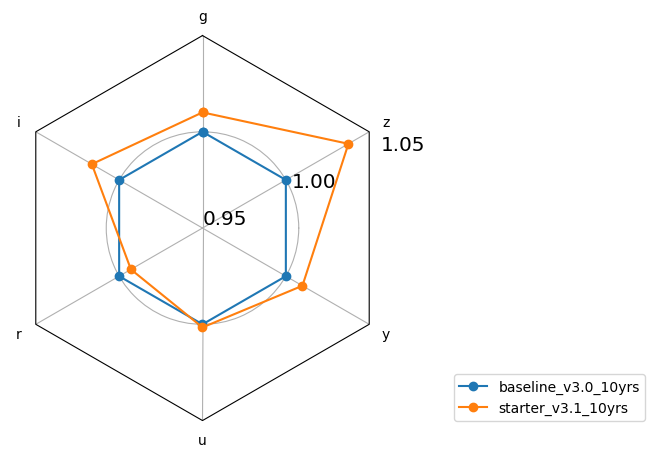

In [16]:
runs = ['baseline_v3.0_10yrs', 'starter_v3.1_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [17]:
mag_data.loc[runs]

,g,i,r,u,y,z
baseline_v3.0_10yrs,26.688123,26.26460,26.818287,25.668262,24.756955,25.524781
starter_v3.1_10yrs,26.698215,26.28098,26.811239,25.669870,24.766895,25.562311


# Compare number of SNe in the DDFs
# Huge boost in all the DDFs.

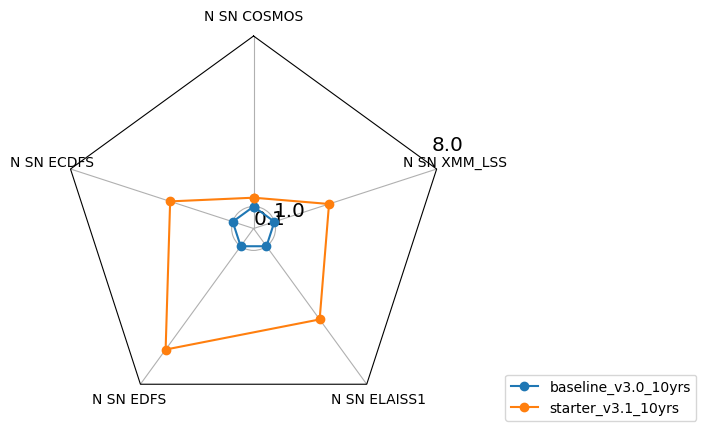

In [18]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 8], bbox_to_anchor=(1.65, 0))

# SNe redshift limits in the DDFs. No big changes

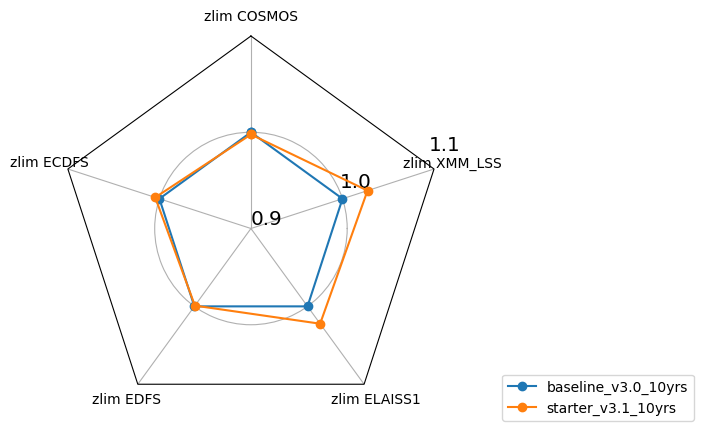

In [19]:
cols = [col for col in ddf_data.columns.values.tolist() if 'zlim' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs', mag_cols='all')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [20]:
ddf_data


,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335
filters_uy_v3.1_10yrs,392.296186,66.345410,119.120007,31.918175,52.455098,0.597483,0.577995,0.530214,0.595695,0.564129
filters_uz_v3.1_10yrs,377.023944,60.966517,106.881873,33.109030,52.624389,0.596862,0.559737,0.510642,0.581440,0.564676
heavy_plane_v3.1_10yrs,494.692623,265.988504,465.277838,180.748018,204.259975,0.591074,0.580152,0.527244,0.568824,0.566221
light_plane_v3.1_10yrs,495.944050,268.278326,461.637403,176.235935,205.034481,0.586987,0.580488,0.526366,0.569684,0.565378
m2_starter_v3.1_10yrs,493.955456,268.234021,467.454780,175.783421,202.691063,0.592349,0.579559,0.526786,0.569267,0.567768
more_u_utw_100_v3.1_10yrs,492.991131,266.945207,462.443062,180.655006,200.375977,0.592054,0.580188,0.525936,0.568901,0.566366


In [21]:
data.index

Index(['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
       'baseline_v3.0_10yrs', 'filters_uy_v3.1_10yrs', 'filters_uz_v3.1_10yrs',
       'heavy_plane_v3.1_10yrs', 'light_plane_v3.1_10yrs',
       'm2_starter_v3.1_10yrs', 'more_u_utw_100_v3.1_10yrs',
       'more_u_utw_12_v3.1_10yrs', 'more_u_utw_150_v3.1_10yrs',
       'more_u_utw_200_v3.1_10yrs', 'more_u_utw_24_v3.1_10yrs',
       'more_u_utw_50_v3.1_10yrs', 'no_plane_v3.1_10yrs', 'noroll_v3.1_10yrs',
       'old_mjd0_uz_v3.1_10yrs', 'old_mjd0_v3.1_10yrs',
       'retro_baseline_v2.0_10yrs', 'starter_v3.1_10yrs',
       'threeroll_v3.1_10yrs', 'upu_v3.1_10yrs', 'weather_cloudso0v3.1_10yrs',
       'weather_cloudso10v3.1_10yrs', 'weather_cloudso12v3.1_10yrs',
       'weather_cloudso14v3.1_10yrs', 'weather_cloudso16v3.1_10yrs',
       'weather_cloudso18v3.1_10yrs', 'weather_cloudso1v3.1_10yrs',
       'weather_cloudso20v3.1_10yrs', 'weather_cloudso2v3.1_10yrs',
       'weather_cloudso30v3.1_10yrs', 'weather_clo

In [22]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs', 'starter_v3.1_10yrs']

In [23]:
sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
retro_baseline_v2.0_10yrs,0.804328,0.176701,0.0883,0.1533,848.0,97124.012102,0.281304,34.632263,449.0,2763.0,3982.0,720.0,179640.718155,0.9048,0.623933,0.705953,1.000000,0.142390,NaN
baseline_v2.0_10yrs,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,0.282012,37.908126,443.0,3433.0,4544.0,1879.0,168086.074111,0.9294,0.642021,0.719635,1.000000,0.124696,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,0.283756,38.560143,443.0,3585.0,4777.0,1918.0,163815.013503,0.9286,0.647553,0.723197,0.999931,0.129250,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,0.289980,39.794283,440.0,3950.0,5215.0,1920.0,172453.127988,0.9304,0.657476,0.723913,0.999965,0.130637,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,0.293926,38.643260,423.0,4308.0,5654.0,1950.0,168032.537231,0.9326,0.642155,0.722293,0.999965,0.129763,0.0376
starter_v3.1_10yrs,0.808140,0.188156,0.3396,0.4749,795.0,118299.517334,0.302043,39.264445,422.0,3497.0,5408.0,2002.0,171783.514516,0.9280,0.636065,0.720482,0.999965,0.128209,0.0428


# Major science metrics changes over simulation version

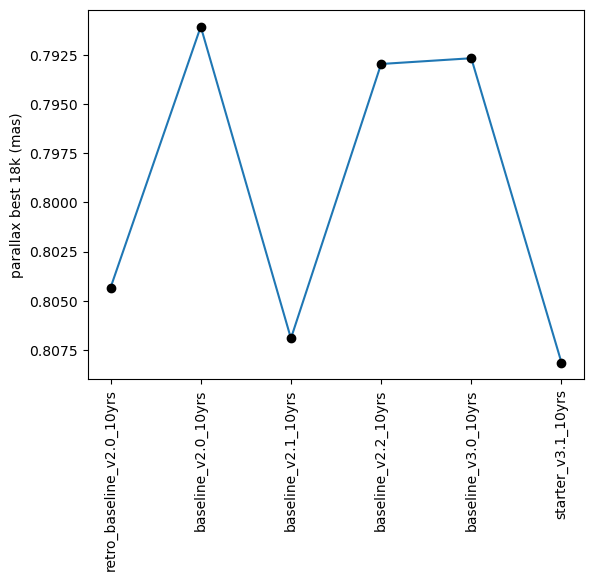

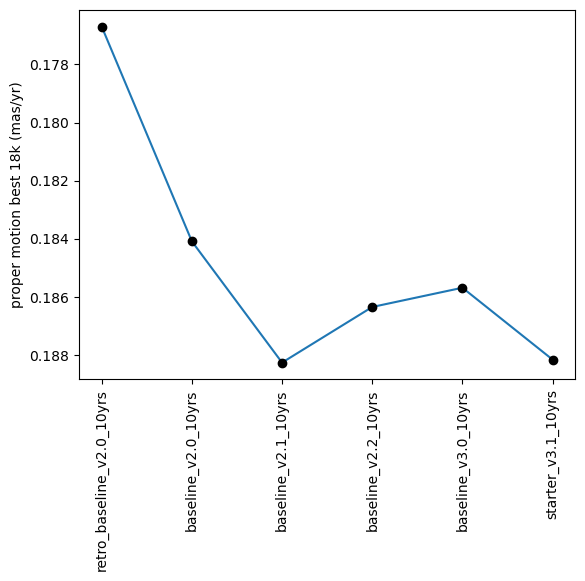

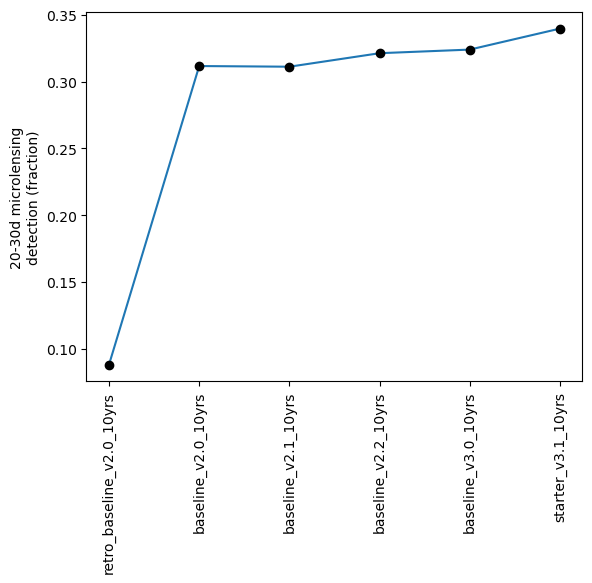

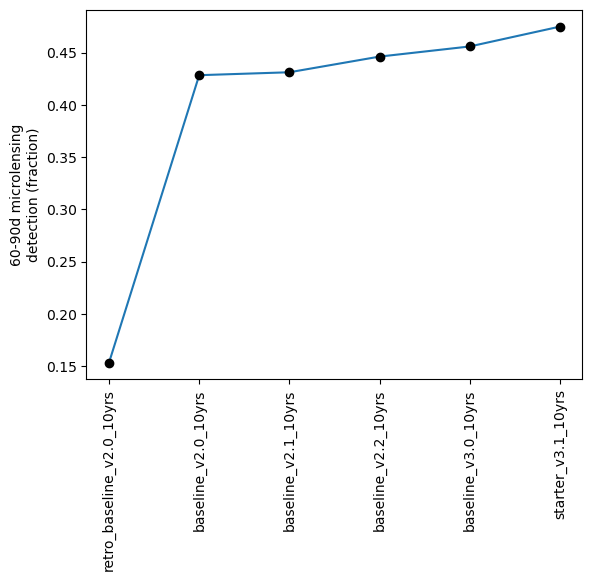

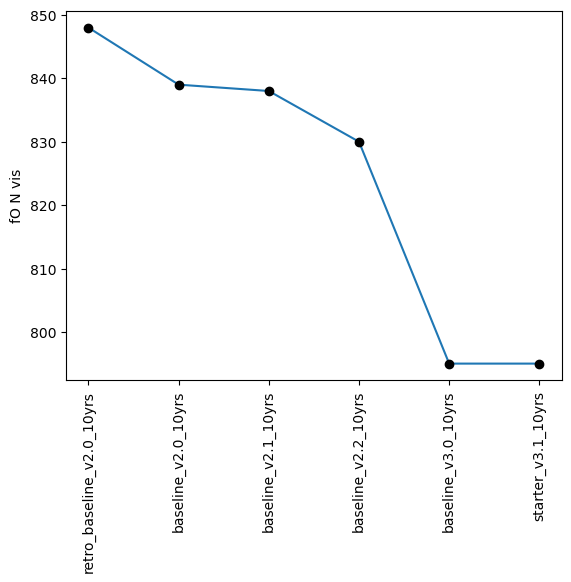

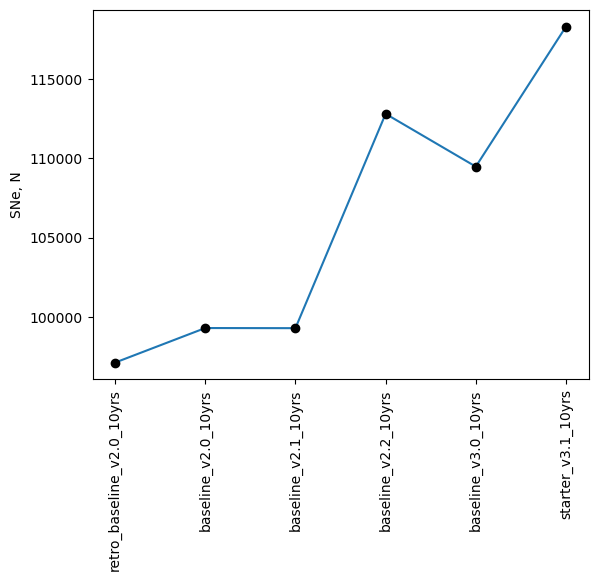

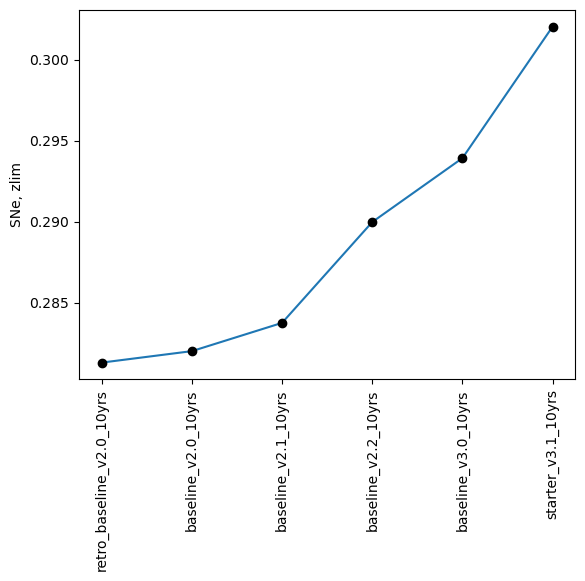

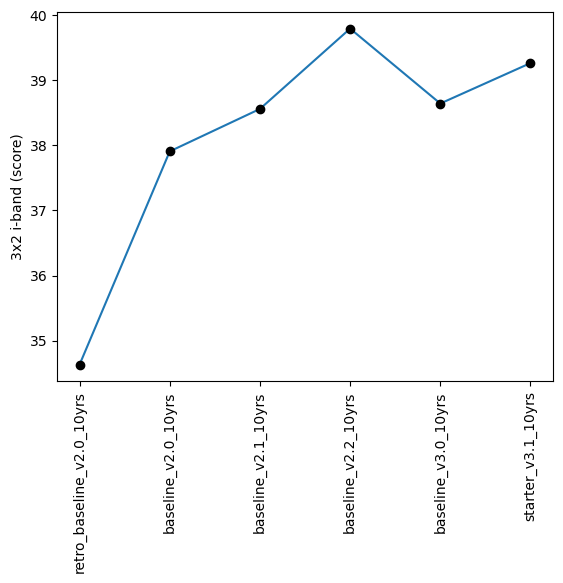

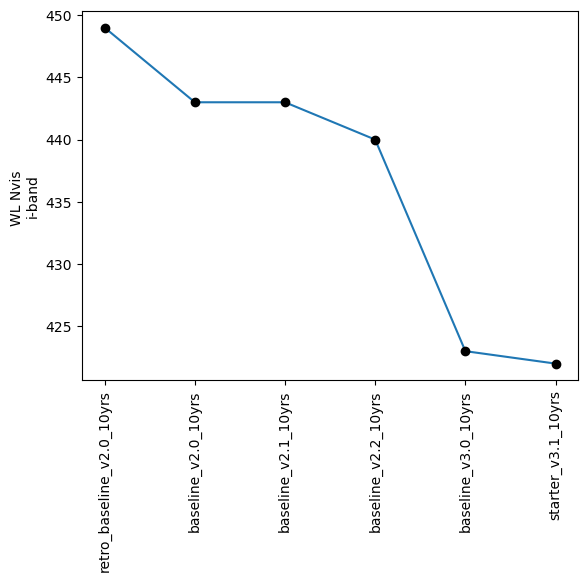

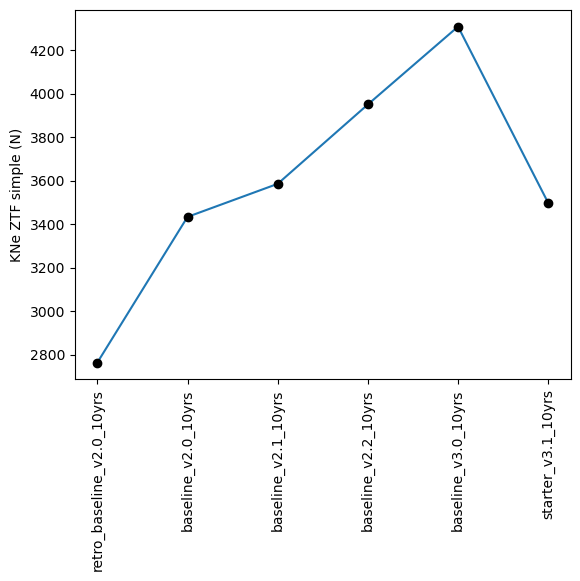

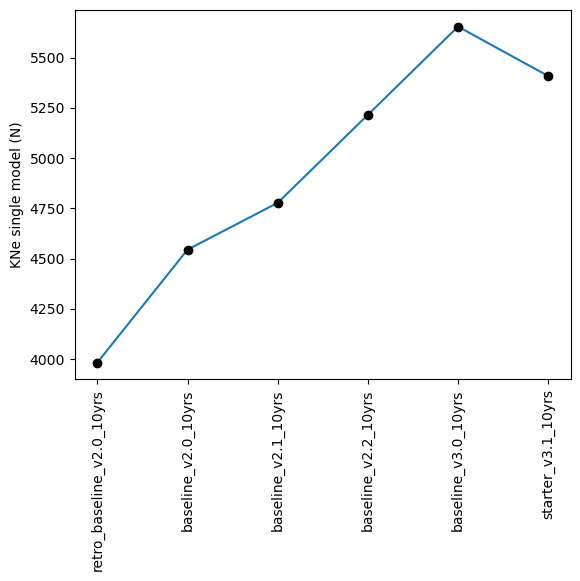

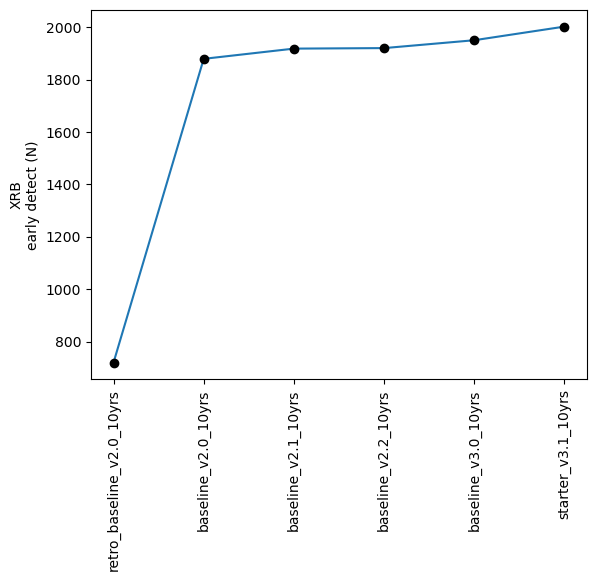

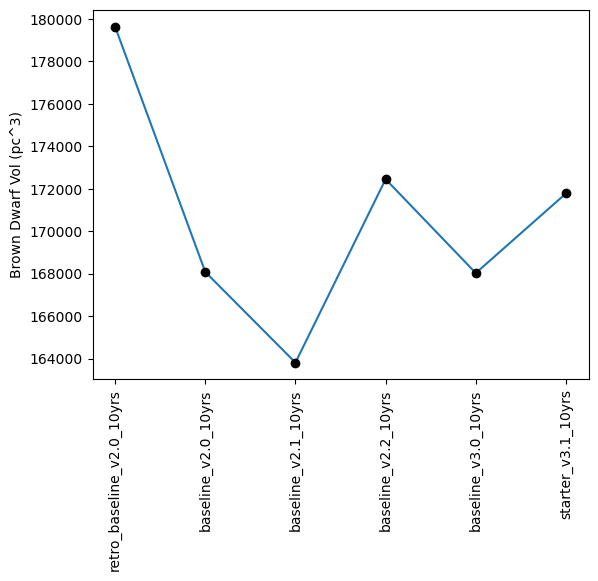

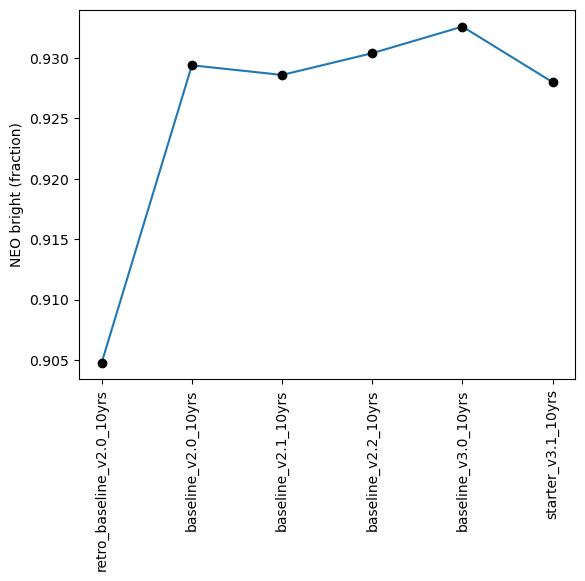

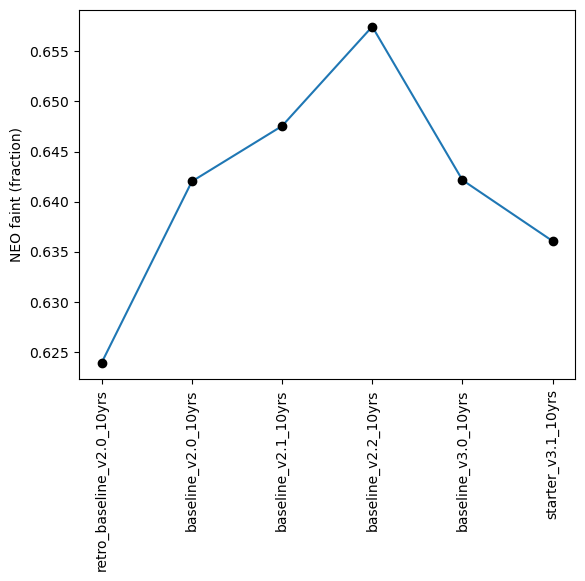

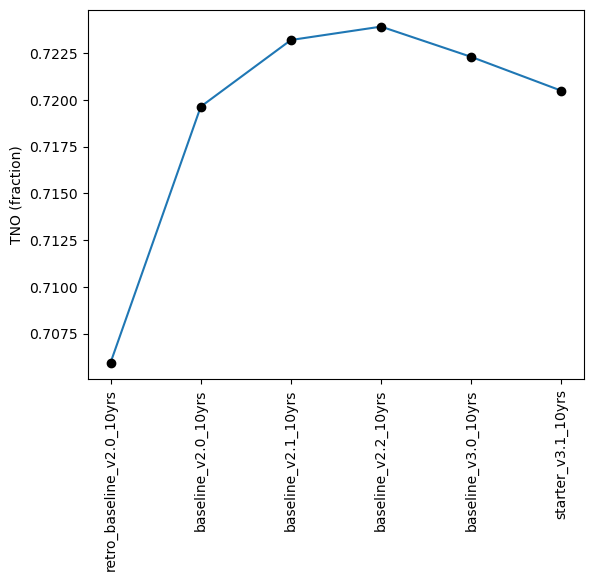

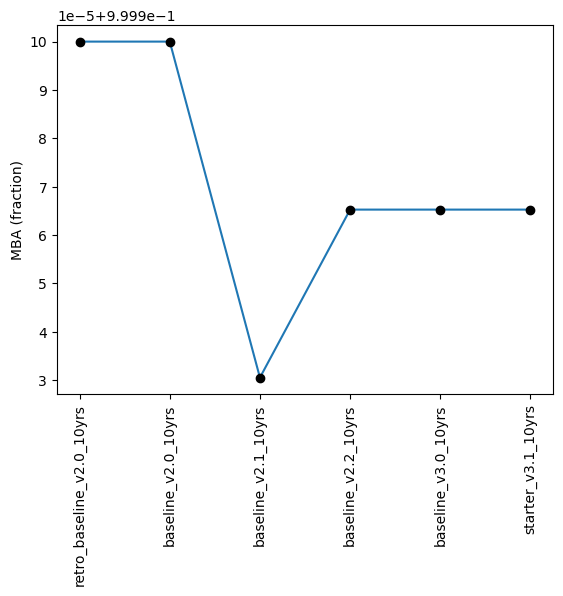

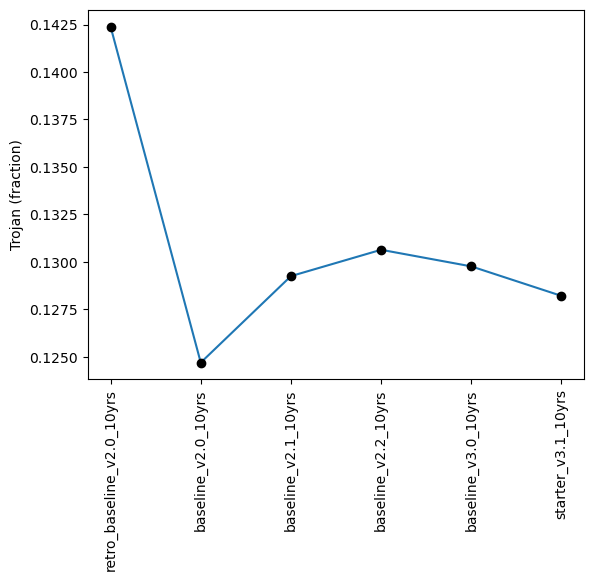

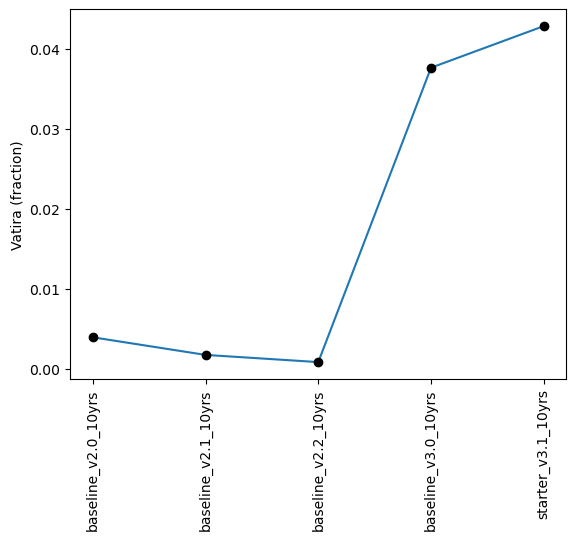

In [24]:
#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col])
    label_add = ''
    ax.plot(sub_data[col], 'ko')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

# DDF performance over simulation version

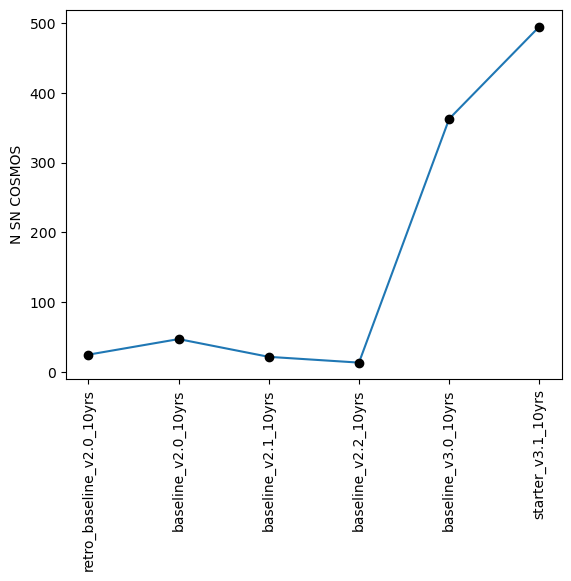

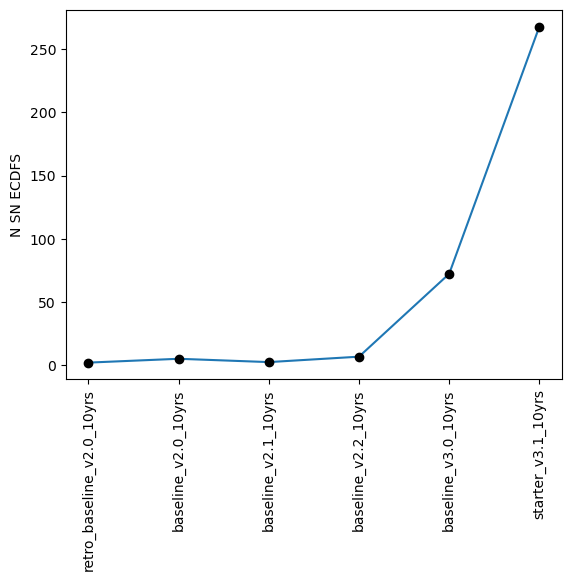

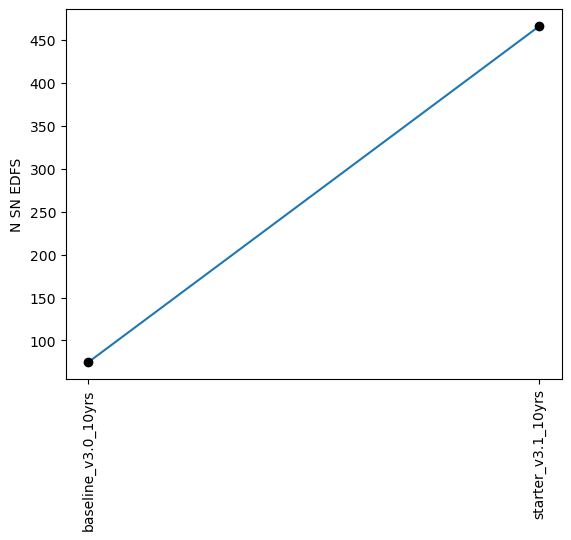

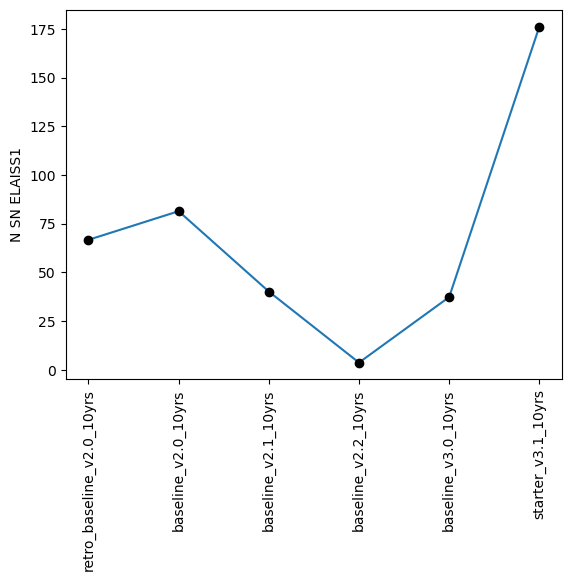

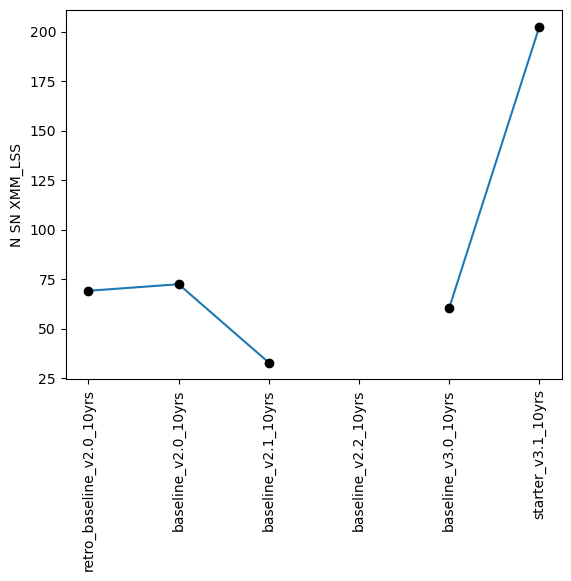

In [25]:

for col in sub_ddf.columns[0:5]:
    fig, ax = plt.subplots()
    ax.plot(sub_ddf[col])
    ax.plot(sub_ddf[col], 'ko')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', labelrotation = 90)

In [26]:
# check that we have the depths and weighted seeing per year
cols = [col for col in data_loaded.columns if 'coadd g' in col and 'Median' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median coadd g, year<1 night<365 and g HealpixSlicer      25.465065
Median coadd g, year<10 night<3652 and g HealpixSlicer    26.698179
Median coadd g, year<2 night<730 and g HealpixSlicer      25.816407
Median coadd g, year<3 night<1095 and g HealpixSlicer     26.093548
Median coadd g, year<4 night<1461 and g HealpixSlicer     26.264865
Median coadd g, year<5 night<1826 and g HealpixSlicer     26.364758
Median coadd g, year<6 night<2191 and g HealpixSlicer     26.458256
Median coadd g, year<7 night<2556 and g HealpixSlicer     26.536113
Median coadd g, year<8 night<2922 and g HealpixSlicer     26.592907
Median coadd g, year<9 night<3287 and g HealpixSlicer     26.643219
Name: starter_v3.1_10yrs, dtype: float64

In [27]:
cols = [col for col in data_loaded.columns if 'Median SNR-weighted FWHMeff g' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median SNR-weighted FWHMeff g, year<1 night<365 and g HealpixSlicer      0.920467
Median SNR-weighted FWHMeff g, year<10 night<3652 and g HealpixSlicer    1.082621
Median SNR-weighted FWHMeff g, year<2 night<730 and g HealpixSlicer      0.968041
Median SNR-weighted FWHMeff g, year<3 night<1095 and g HealpixSlicer     0.974764
Median SNR-weighted FWHMeff g, year<4 night<1461 and g HealpixSlicer     0.968498
Median SNR-weighted FWHMeff g, year<5 night<1826 and g HealpixSlicer     0.994874
Median SNR-weighted FWHMeff g, year<6 night<2191 and g HealpixSlicer     1.015181
Median SNR-weighted FWHMeff g, year<7 night<2556 and g HealpixSlicer     1.041358
Median SNR-weighted FWHMeff g, year<8 night<2922 and g HealpixSlicer     1.070528
Median SNR-weighted FWHMeff g, year<9 night<3287 and g HealpixSlicer     1.079788
Name: starter_v3.1_10yrs, dtype: float64